Encontrando Série temporal 

In [1]:
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from  darts.utils.model_selection import TimeSeries

from pyspark.sql import SparkSession

In [2]:
# Create SparkSession
spark = SparkSession.builder \
           .appName('SparkByExamples.com') \
           .config("spark.jars", "C:\\Program Files (x86)\\PostgreSQL\\pgJDBC\\postgresql-42.7.2.jar")\
           .getOrCreate()

Impostando d

In [3]:
url = "jdbc:postgresql://localhost:5432/ecommerce"
properties = {
    "user": "postgres",
    "password": "datascience007",
    "driver": "org.postgresql.Driver"
}

Criando uma série temporal(série temporal encontrada)

In [4]:
query = '''
( SELECT oo.order_purchase_timestamp, oi.price
    FROM olist_order AS oo
        INNER JOIN olist_order_items AS oi
            ON oi.order_id = oo.order_id
    WHERE oo.status_ = 'ok' ) AS tmp
'''

In [5]:
data = spark.read.format('jdbc')\
    .option("url", url)\
    .option("dbtable", query)\
    .option("user", properties["user"])\
    .option("password", properties["password"])\
    .option("driver", properties["driver"])\
    .load()

In [6]:
dataset = data.toPandas()

Passando para datetime o atributo 'order_purchase_timestamp'

In [7]:
dataset['data'] = dataset['order_purchase_timestamp'].dt.date

Fazendo um agrupamento para verificar os a receita total de cada datatime

In [8]:
subset = dataset.groupby(by=['data'])['price'].sum().reset_index()

Passando novamente para datetime

In [9]:
subset['data'] = pd.to_datetime(subset['data'])

Preenchendo com 0 os dias que deveriam ser computados , para manter uma certa ordem historica

In [10]:
dicionario = {
    'data':[],
    'receita':[]
}
for i in subset['data'].dt.year.unique():

    x_ = subset.loc[subset['data'].dt.year==i]
    dias = ((x_['data'].max() -  x_['data'].min()).days//7)+ 1
    

    range_ = pd.date_range(start=x_['data'].min(), end=x_['data'].max(), freq='W')

    for enum, date_ in enumerate(range_):
        dados = subset.loc[subset['data']==date_,'price'].values
        if len(dados) == 0:dados = [0]
        dicionario['data'].append(date_)
        dicionario['receita'].append(dados[0])

subsetModificiado = pd.DataFrame(dicionario)
subsetModificiado['data'] = pd.to_datetime(subsetModificiado['data'])

O Objetivo é encontrar receita total do proximo mes

<Axes: xlabel='time'>

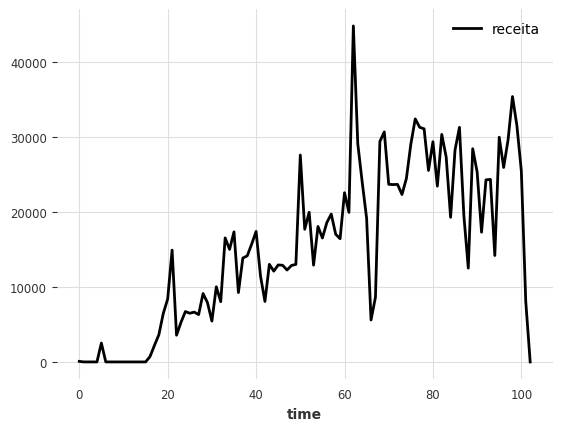

In [11]:
TimeSeries.from_series(subsetModificiado['receita']).plot()

> Série histórica da receita total

In [12]:
subsetModificiado.loc[subsetModificiado['data'].dt.year==2016]

,data,receita
time,,
0,2016-09-04,72.889999
1,2016-09-11,0.000000
2,2016-09-18,0.000000
3,2016-09-25,0.000000
4,2016-10-02,0.000000
5,2016-10-09,2519.199951
6,2016-10-16,0.000000
7,2016-10-23,0.000000
8,2016-10-30,0.000000


> devido a baixa qualidade de informção desse periodo será removido da série

In [13]:
subset.iloc[len(subset)-1,:]

data     2018-09-03 00:00:00
price                  145.0
Name: 613, dtype: object

> Essa linha vamos assumir nesse dia não foi coletando tando dados de vendas esse forma vamos excluir essa linha

In [14]:
# removendo o ano de 2016
subsetModificiado.drop(
    index=subsetModificiado.loc[subsetModificiado['data'].dt.year==2016].index,
    inplace=True
    )

In [15]:
# removendo o ultimo dia de 2018
index_ = subsetModificiado\
            .loc[subsetModificiado['data'].dt.year==2018]['data'].idxmax()
subsetModificiado.drop(
    index=index_,
    inplace=True
    )

Plotando novamente a serie temporal

In [16]:
series = TimeSeries.from_series(subsetModificiado['receita'])

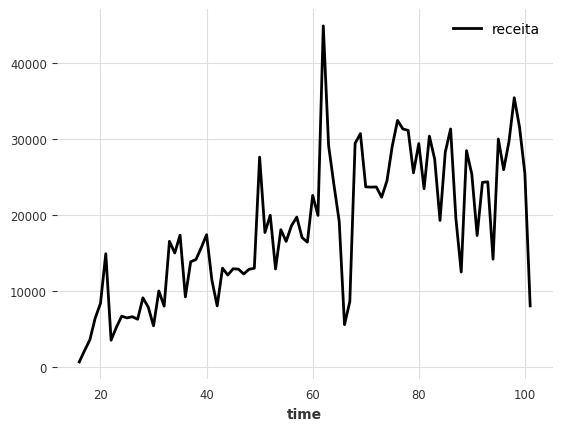

In [17]:
TimeSeries.from_series(subsetModificiado['receita']).plot()
plt.show()

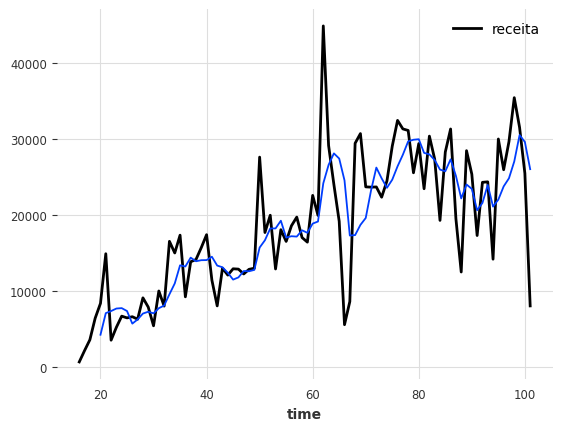

In [18]:
series.plot()
plt.plot(subsetModificiado['receita'].rolling(5).mean())
plt.show()

> Podemos ver que há uma tendencia de alta até o periodo

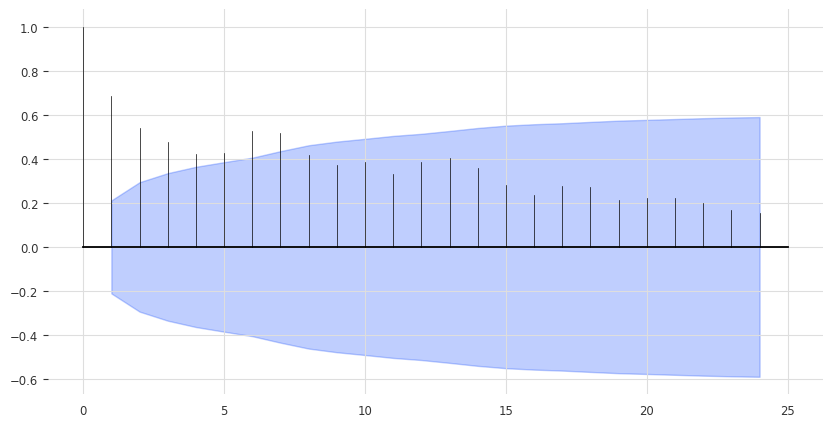

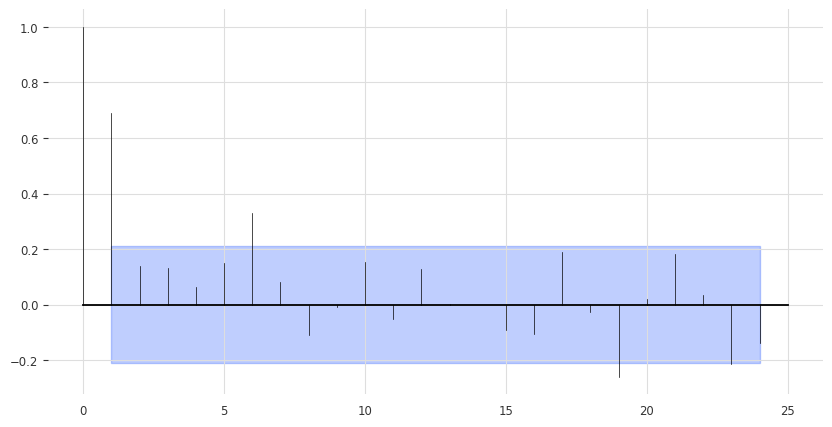

In [19]:
from darts.utils.statistics import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)

In [20]:
from src.test_ import adf_test

adf_test(subsetModificiado['receita'])

Teste de Dickey-Fuller Aumentado (ADF):
Estatística ADF: -1.5779
Valor-p: 0.4947
Número de lags usados: 5
Número de observações usadas: 80

Valores Críticos:
Nível de Significância  Valor Crítico
                    1%      -3.514869
                    5%      -2.898409
                   10%      -2.586439

Interpretação:
O valor-p é maior que 0.05. Não rejeitamos a hipótese nula.
A série temporal NÃO É ESTACIONÁRIA.


Fazendo transformação logaritimica para transforma a série em uum processo estacionario

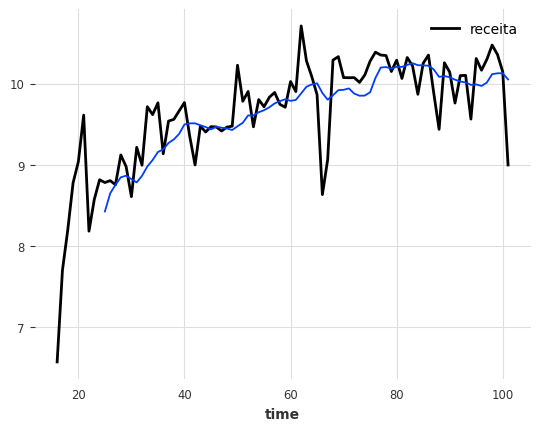

In [42]:
import numpy as np
series.map(lambda x: np.log1p(x)).plot()
plt.plot(subsetModificiado['receita'].apply(lambda x:np.log1p(x)).rolling(10).mean())

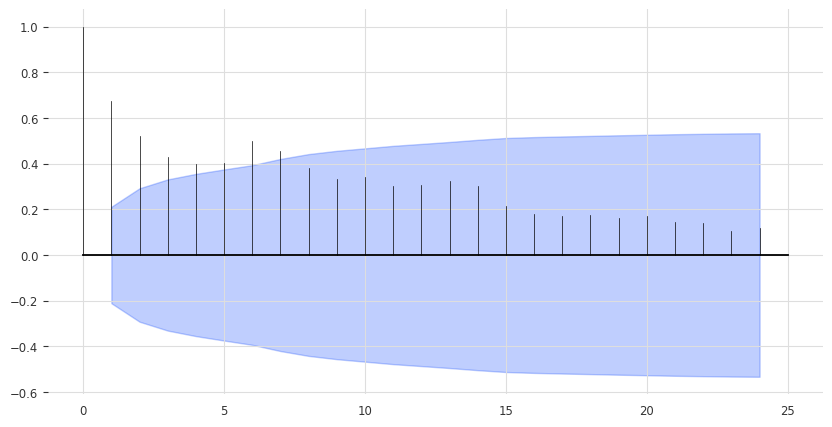

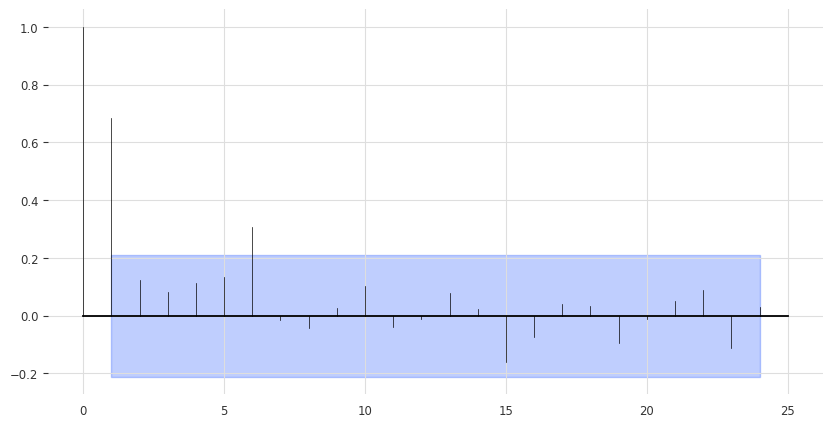

In [45]:
plot_acf(series.map(lambda x: np.log1p(x)))
plot_pacf(series.map(lambda x: np.log1p(x)))

In [43]:
adf_test(subsetModificiado['receita'].apply(lambda x:np.log1p(x)))

Teste de Dickey-Fuller Aumentado (ADF):
Estatística ADF: -5.2146
Valor-p: 0.0000
Número de lags usados: 0
Número de observações usadas: 85

Valores Críticos:
Nível de Significância  Valor Crítico
                    1%      -3.509736
                    5%      -2.896195
                   10%      -2.585258

Interpretação:
O valor-p é menor que 0.05. Rejeitamos a hipótese nula.
A série temporal é ESTACIONÁRIA.


Fazendo a diferenciação da série e depois verificar sé o processo é estacionario

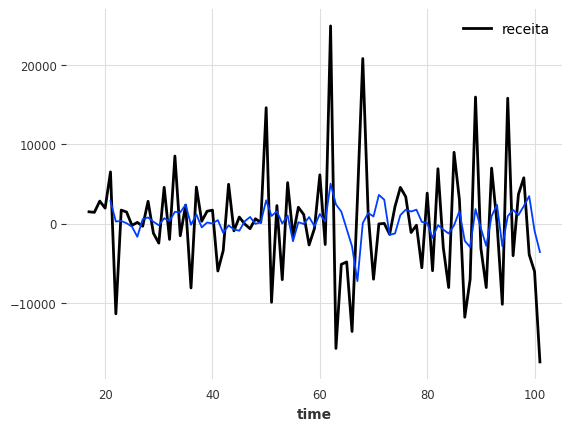

In [33]:
series.diff().plot()
plt.plot(subsetModificiado['receita'].diff().rolling(5).mean())

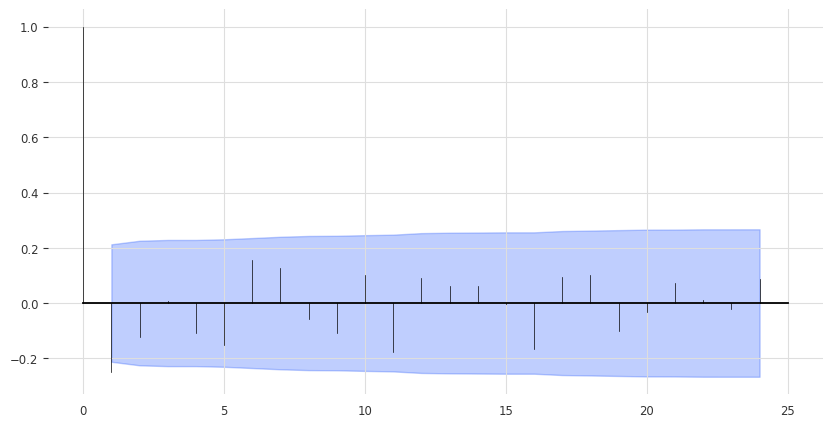

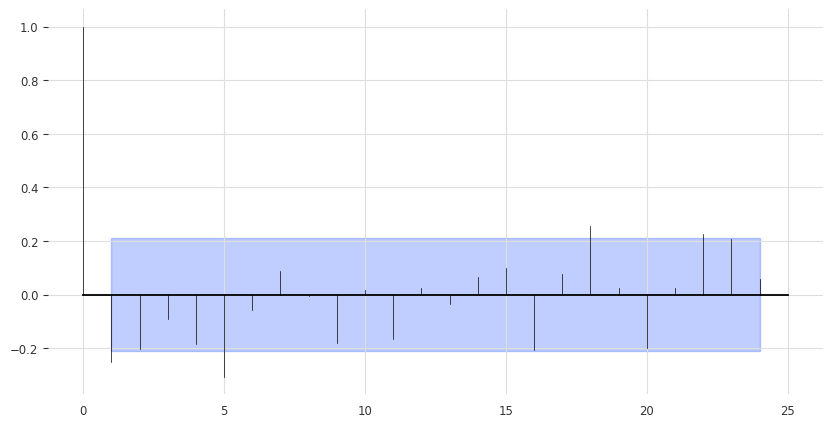

In [46]:
plot_acf(series.diff())

plot_pacf(series.diff())

In [37]:
adf_test(subsetModificiado['receita'].diff().fillna(0))

Teste de Dickey-Fuller Aumentado (ADF):
Estatística ADF: -6.7358
Valor-p: 0.0000
Número de lags usados: 5
Número de observações usadas: 80

Valores Críticos:
Nível de Significância  Valor Crítico
                    1%      -3.514869
                    5%      -2.898409
                   10%      -2.586439

Interpretação:
O valor-p é menor que 0.05. Rejeitamos a hipótese nula.
A série temporal é ESTACIONÁRIA.


In [ ]:
from darts.